In [16]:
import pandas as pd
import time
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession, types
import pyspark.sql.functions as F
from  pyspark.sql.functions import col

spark = (
    SparkSession.builder.config("spark.sql.debug.maxToStringFields", 100)
    .appName("reviews")
    .getOrCreate()
)

data_filepath = "../data/cleaned_steam_reviews"
steam_games_filepath = "../data/cleaned_steam_games"

In [2]:
steam_reviews = spark.read.parquet(data_filepath)

In [17]:
steam_games = spark.read.parquet(steam_games_filepath)

In [5]:
steam_reviews.show(10)

+------+--------------------+---------+--------+------------------------------------+-----------------+-----------------+-----------+-------------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+-----------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+-------+
|app_id|            app_name|review_id|language|                              review|timestamp_created|timestamp_updated|recommended|votes_helpful|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|   author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_last_two_weeks|author_playtime_at_review|author_last_played|game_id|
+------+--------------------+---------+--------+------------------------------------+-----------------+-----------------+-----------+-------------+-------

## Probability of recommended by language

In [42]:
recommended = steam_reviews.select("language", "recommended") \
                            .withColumn("recommended", col("recommended").cast("int")) \
                            .where(col("recommended").isNotNull()) \
                            .groupBy("language") \
                            .agg(F.avg("recommended").alias("recommended_prob")) \
                            .orderBy("recommended_prob", ascending=False)

In [43]:
recommended.show()

+----------+------------------+
|  language|  recommended_prob|
+----------+------------------+
|  romanian|0.9582124201973302|
|     latam|0.9520611968485913|
|portuguese|0.9520108859993952|
|    polish|0.9505445411855808|
| brazilian|0.9500624863500692|
|   spanish|0.9365137679723239|
|     czech|0.9337594256301164|
|   swedish|0.9331786473007789|
| hungarian|0.9314001372683597|
| ukrainian|0.9310029282576867|
|     dutch| 0.929525534461011|
|vietnamese|0.9278688524590164|
|    danish|0.9268829149077983|
|    french|0.9256060004230009|
| norwegian|0.9238913760988203|
|   finnish|0.9229994643813605|
|     greek|0.9218472468916519|
|      thai|0.9152453373266691|
|   italian|0.9137784914581382|
|    german| 0.908926752922741|
+----------+------------------+
only showing top 20 rows



<AxesSubplot:title={'center':'Probability of recommended by language'}, xlabel='Language', ylabel='Probability of recommended'>

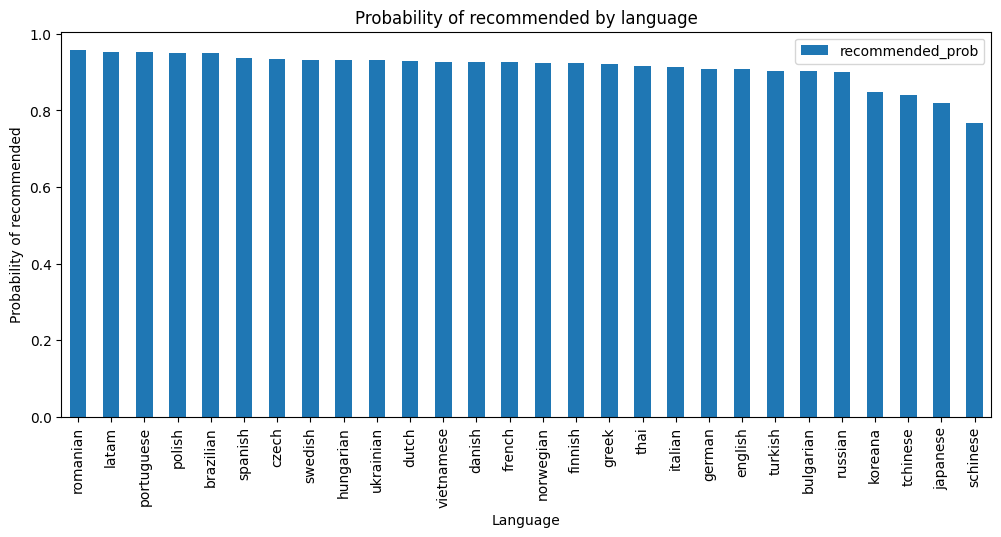

In [51]:
recommended.toPandas().plot.bar(x="language",
                                y="recommended_prob", figsize=(12, 5),
                                title="Probability of recommended by language",
                                xlabel = "Language",
                                ylabel = "Probability of recommended")

## Statistics by language

In [3]:
stats_by_language = steam_reviews.select("language", "recommended", "received_for_free", "author_num_games_owned", "author_playtime_forever", "author_playtime_at_review") \
                                .withColumn("recommended", col("recommended").cast("int")) \
                                .withColumn("received_for_free", col("received_for_free").cast("int")) \
                                .where(col("recommended").isNotNull() & col("received_for_free").isNotNull() & col("author_num_games_owned").isNotNull() & col("author_playtime_forever").isNotNull() & col("author_playtime_at_review").isNotNull()) \
                                .groupBy("language") \
                                .agg( \
                                        F.avg("recommended").alias("recommended_prob"), \
                                        F.avg("received_for_free").alias("received_for_free_prob"), \
                                        F.avg("author_num_games_owned").alias("author_num_games_owned_avg"), \
                                        F.avg("author_playtime_forever").alias("author_playtime_forever_avg"), \
                                        F.avg("author_playtime_at_review").alias("author_playtime_at_review_avg") \
                                    ) \
                                .orderBy("recommended_prob", ascending=False)

In [4]:
stats_by_language.show()

+----------+------------------+----------------------+--------------------------+---------------------------+-----------------------------+
|  language|  recommended_prob|received_for_free_prob|author_num_games_owned_avg|author_playtime_forever_avg|author_playtime_at_review_avg|
+----------+------------------+----------------------+--------------------------+---------------------------+-----------------------------+
|  romanian|0.9581682718517173|   0.10986734508449936|         62.42409594766491|         14485.833981464655|            6388.721606396511|
|     latam| 0.952068386505877|   0.03600595328957411|        119.65022515646466|          10865.81115478553|            6341.518394138299|
|portuguese|0.9520650642918806|  0.058491223287443016|          82.4140124494525|          17340.90652308904|              8644.8450936738|
|    polish|0.9505781531391666|   0.04132149288952369|          90.0342023225486|         11938.582343662672|             6441.90535676582|
| brazilian|0.950112

<AxesSubplot:title={'center':'Average Playtime by language'}, xlabel='Language', ylabel='Average Playtime (minutes)'>

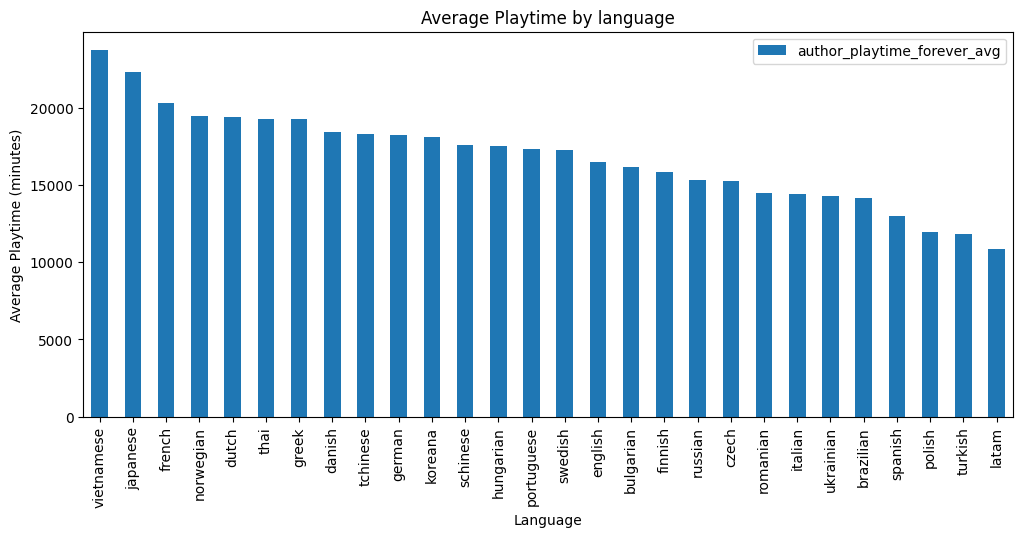

In [10]:
author_playtime_forever_avg = stats_by_language.select("language", "author_playtime_forever_avg").orderBy("author_playtime_forever_avg", ascending=False)
author_playtime_forever_avg.toPandas().plot.bar(x="language",
                                                y="author_playtime_forever_avg", figsize=(12, 5),
                                                title="Average Playtime by language",
                                                xlabel = "Language",
                                                ylabel = "Average Playtime (minutes)")

<AxesSubplot:title={'center':'Average Number of Games Owned by language'}, xlabel='Language', ylabel='Average Number of Games Owned'>

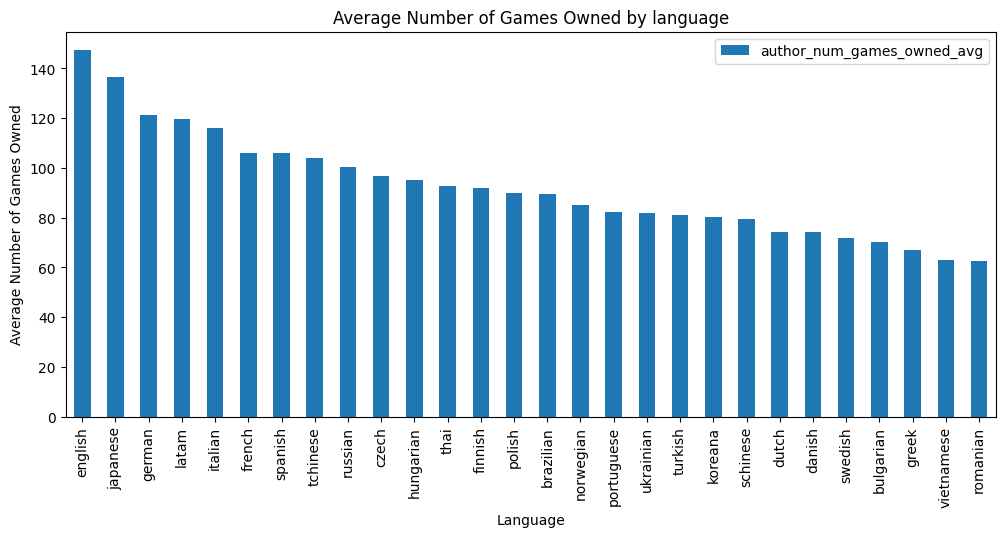

In [13]:
author_num_games_owned_avg = stats_by_language.select("language", "author_num_games_owned_avg").orderBy("author_num_games_owned_avg", ascending=False)
author_num_games_owned_avg.toPandas().plot.bar(x="language",
                                                y="author_num_games_owned_avg", figsize=(12, 5),
                                                title="Average Number of Games Owned by language",
                                                xlabel = "Language",
                                                ylabel = "Average Number of Games Owned")

<AxesSubplot:title={'center':'Average Playtime at Review by language'}, xlabel='Language', ylabel='Average Playtime at Review (minutes)'>

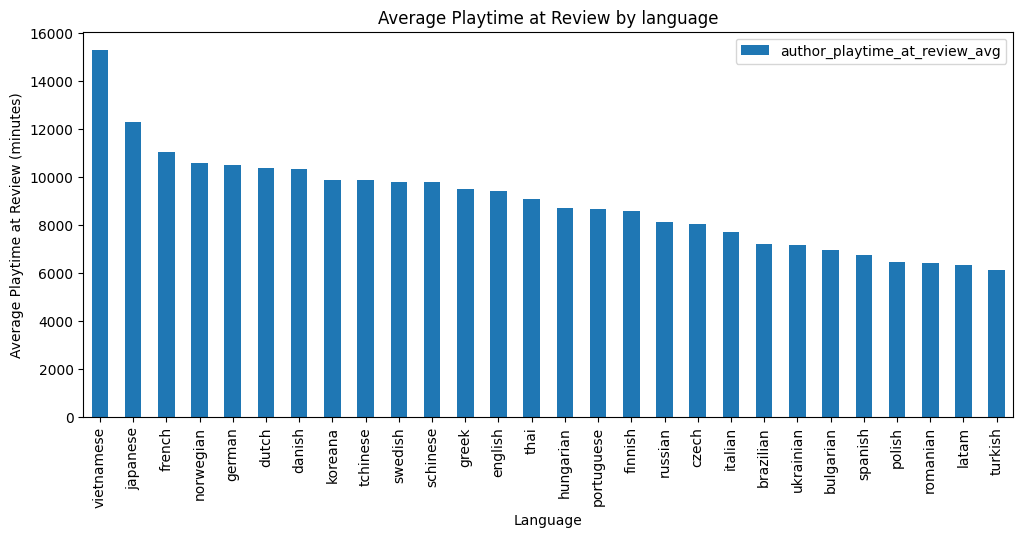

In [12]:
author_playtime_at_review_avg = stats_by_language.select("language", "author_playtime_at_review_avg").orderBy("author_playtime_at_review_avg", ascending=False)
author_playtime_at_review_avg.toPandas().plot.bar(x="language",
                                                    y="author_playtime_at_review_avg", figsize=(12, 5),
                                                    title="Average Playtime at Review by language",
                                                    xlabel = "Language",
                                                    ylabel = "Average Playtime at Review (minutes)")

<AxesSubplot:title={'center':'Received for Free Probability by language'}, xlabel='Language', ylabel='Received for Free'>

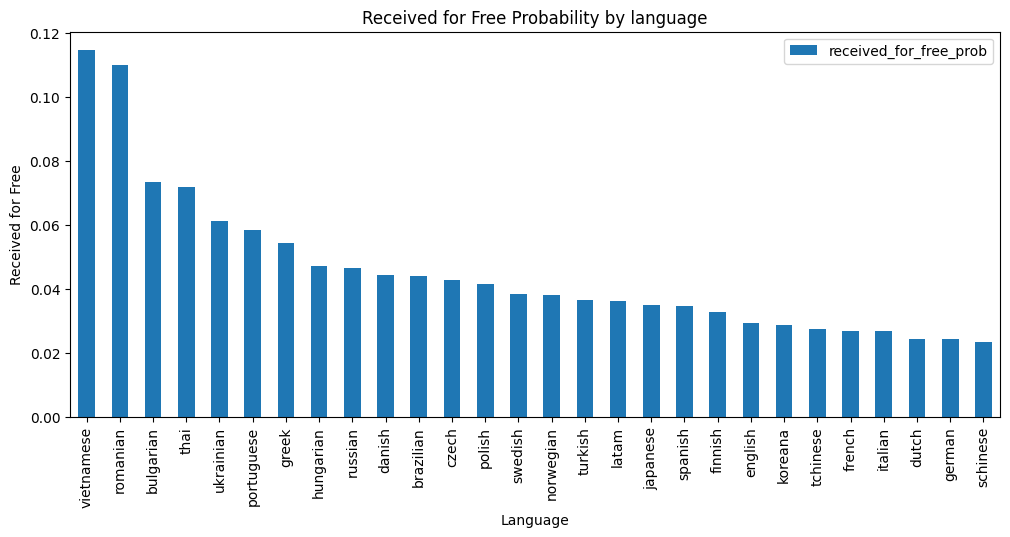

In [15]:
received_for_free_prob = stats_by_language.select("language", "received_for_free_prob").orderBy("received_for_free_prob", ascending=False)
received_for_free_prob.toPandas().plot.bar(x="language",
                                            y="received_for_free_prob", figsize=(12, 5),
                                            title="Received for Free Probability by language",
                                            xlabel = "Language",
                                            ylabel = "Received for Free")

## Regional difference of Recommended Probability for each game genre

In [57]:
recommended_regional = steam_reviews.select("app_id", "language", "recommended") \
                                    .withColumn("recommended", col("recommended").cast("int")) \
                                    .where(col("recommended").isNotNull())
                                    # .groupBy("language") \
                                    # .agg(F.avg("recommended").alias("recommended_prob")) \
                                    # .orderBy("recommended_prob", ascending=False)

tags_map = steam_games.select("game_id", F.explode_outer(F.split(col("popular_tags"),",")).alias("tags")) \
                        .drop("popular_tags") \
                        .where(col("tags") != F.lit("null"))

top_20_tags = tags_map.groupBy("tags") \
                        .count() \
                        .orderBy("count", ascending=False) \
                        .limit(20) \
                        .select("tags") \
                        .distinct() \
                        .orderBy("tags")

tags = tags_map.join(top_20_tags, "tags").select("game_id", tags_map["tags"]).distinct()

languages = recommended_regional.select("language").distinct().orderBy("language")

# tags = tags_map.select("game_id", "tags").distinct()


# recommended_regional.show()
# genres.show()



In [34]:
# recommended_regional_by_genre.show()

+------+--------+-----------+--------------------+
|app_id|language|recommended|                tags|
+------+--------+-----------+--------------------+
|578080|schinese|          0|       Battle Royale|
|578080|schinese|          0|        Online Co-Op|
|578080|schinese|          0|             Shooter|
|578080|schinese|          0|        First-Person|
|578080|schinese|          0|           Difficult|
|578080|schinese|          0|            Tactical|
|578080|schinese|          0|Third-Person Shooter|
|578080|schinese|          0|            Survival|
|578080|schinese|          0|             Stealth|
|578080|schinese|          0|              Action|
|578080|schinese|          0|         Multiplayer|
|578080|schinese|          0|        Early Access|
|578080|schinese|          0|                 PvP|
|578080|schinese|          0|               Co-op|
|578080|schinese|          0|                 FPS|
|578080|schinese|          0|         Competitive|
|578080|schinese|          0|  

In [39]:
recommended_regional_by_genre = recommended_regional.join(tags, recommended_regional["app_id"] == tags["game_id"]).drop("game_id")

recommended_regional_by_genre = recommended_regional_by_genre.groupBy("language", "tags") \
                                                                .agg(F.avg("recommended").alias("recommended_prob")) \
                                                                .orderBy("recommended_prob", ascending=False)


In [40]:
recommended_regional_by_genre.show()

+----------+------+------------------+
|  language|  tags|  recommended_prob|
+----------+------+------------------+
|      thai|    2D|0.9871015023818248|
|vietnamese|    2D|0.9863013698630136|
|vietnamese|Puzzle|             0.985|
|      thai|Puzzle|0.9849759615384616|
| brazilian|Puzzle|0.9847516491646288|
|     latam|Puzzle|0.9847081628257592|
|portuguese|Puzzle|0.9845138359989846|
| hungarian|Puzzle|0.9838709677419355|
| brazilian|    2D|0.9836432800857788|
|   spanish|Puzzle|0.9829670207811217|
|  romanian|    2D|       0.982421875|
|portuguese|    2D|0.9821787148594378|
|     latam|    2D|0.9810160224770293|
| hungarian|    2D|0.9808634415186773|
|   spanish|    2D|0.9808374047225812|
| ukrainian|    2D| 0.980160405234276|
|  romanian|Puzzle|0.9799426934097422|
|    polish|Puzzle|0.9790643577151719|
|     greek|Puzzle|0.9788359788359788|
|  romanian|Casual|0.9771748097900815|
+----------+------+------------------+
only showing top 20 rows



In [59]:

top_20_tags_names = map(lambda row: row.asDict(), top_20_tags.collect())
top_20_tags_names = [row["tags"] for row in top_20_tags_names]


languages_names = map(lambda row: row.asDict(), languages.collect())
languages_names = [row["language"] for row in languages_names]

In [60]:
print(top_20_tags_names)
print(languages_names)
print(len(languages_names))

['2D', 'Action', 'Adventure', 'Atmospheric', 'Casual', 'Difficult', 'Early Access', 'Fantasy', 'Free to Play', 'Great Soundtrack', 'Indie', 'Multiplayer', 'Puzzle', 'RPG', 'Simulation', 'Singleplayer', 'Story Rich', 'Strategy', 'VR', 'Violent']
['brazilian', 'bulgarian', 'czech', 'danish', 'dutch', 'english', 'finnish', 'french', 'german', 'greek', 'hungarian', 'italian', 'japanese', 'koreana', 'latam', 'norwegian', 'polish', 'portuguese', 'romanian', 'russian', 'schinese', 'spanish', 'swedish', 'tchinese', 'thai', 'turkish', 'ukrainian', 'vietnamese']
28


In [65]:
recommended_regional_by_genre_dict = list(map(lambda row: row.asDict(), recommended_regional_by_genre.collect()))

In [67]:
language_pos = {}
tags_pos = {}
for pos, language in enumerate(languages_names):
    language_pos[language] = pos
for pos, tag in enumerate(top_20_tags_names):
    tags_pos[tag] = pos

matrix = [ [0] * len(top_20_tags_names) for _ in range(len(languages_names)) ]
print(recommended_regional_by_genre_dict)
for data in recommended_regional_by_genre_dict:
    language = data["language"]
    tag = data["tags"]
    prob = data["recommended_prob"]
    matrix[language_pos[language]][tags_pos[tag]] = prob

[{'language': 'thai', 'tags': '2D', 'recommended_prob': 0.9871015023818248}, {'language': 'vietnamese', 'tags': '2D', 'recommended_prob': 0.9863013698630136}, {'language': 'vietnamese', 'tags': 'Puzzle', 'recommended_prob': 0.985}, {'language': 'thai', 'tags': 'Puzzle', 'recommended_prob': 0.9849759615384616}, {'language': 'brazilian', 'tags': 'Puzzle', 'recommended_prob': 0.9847516491646288}, {'language': 'latam', 'tags': 'Puzzle', 'recommended_prob': 0.9847081628257592}, {'language': 'portuguese', 'tags': 'Puzzle', 'recommended_prob': 0.9845138359989846}, {'language': 'hungarian', 'tags': 'Puzzle', 'recommended_prob': 0.9838709677419355}, {'language': 'brazilian', 'tags': '2D', 'recommended_prob': 0.9836432800857788}, {'language': 'spanish', 'tags': 'Puzzle', 'recommended_prob': 0.9829670207811217}, {'language': 'romanian', 'tags': '2D', 'recommended_prob': 0.982421875}, {'language': 'portuguese', 'tags': '2D', 'recommended_prob': 0.9821787148594378}, {'language': 'latam', 'tags': '2

In [68]:
print(matrix)

[[0.9836432800857788, 0.946446881100509, 0.9586348497047444, 0.9618719184179448, 0.9652063826981406, 0.9391766133284208, 0.8912091250281727, 0.9521589650952742, 0.9441043610419217, 0.9593937105941877, 0.9657246252496448, 0.9391234762874551, 0.9847516491646288, 0.9614441311652698, 0.9398451960289416, 0.9595694996327753, 0.9696505387946538, 0.9276063566658422, 0.9678876066231812, 0.9278931651176056], [0.9630584192439863, 0.8986966060136792, 0.9346866725507502, 0.9389446140427388, 0.9470512268618166, 0.8112109994711793, 0.76875, 0.9082969432314411, 0.9367088607594937, 0.9179251477347341, 0.9426229508196722, 0.8828530940009447, 0.9708029197080292, 0.9437784208350558, 0.8878865979381443, 0.9339055793991416, 0.931321540062435, 0.8456624075319435, 0.9702970297029703, 0.8981288981288982], [0.9734797959984307, 0.9284901746481387, 0.9461913027449655, 0.9475159711839065, 0.952124321730464, 0.8926322765933945, 0.8829829236995361, 0.9402356096159372, 0.9529372496662216, 0.9402056684223727, 0.950944

In [98]:
for i in range(len(matrix)):
    for j in range(len(matrix[0])):
        matrix[i][j] = round(matrix[i][j] * 100, 2)

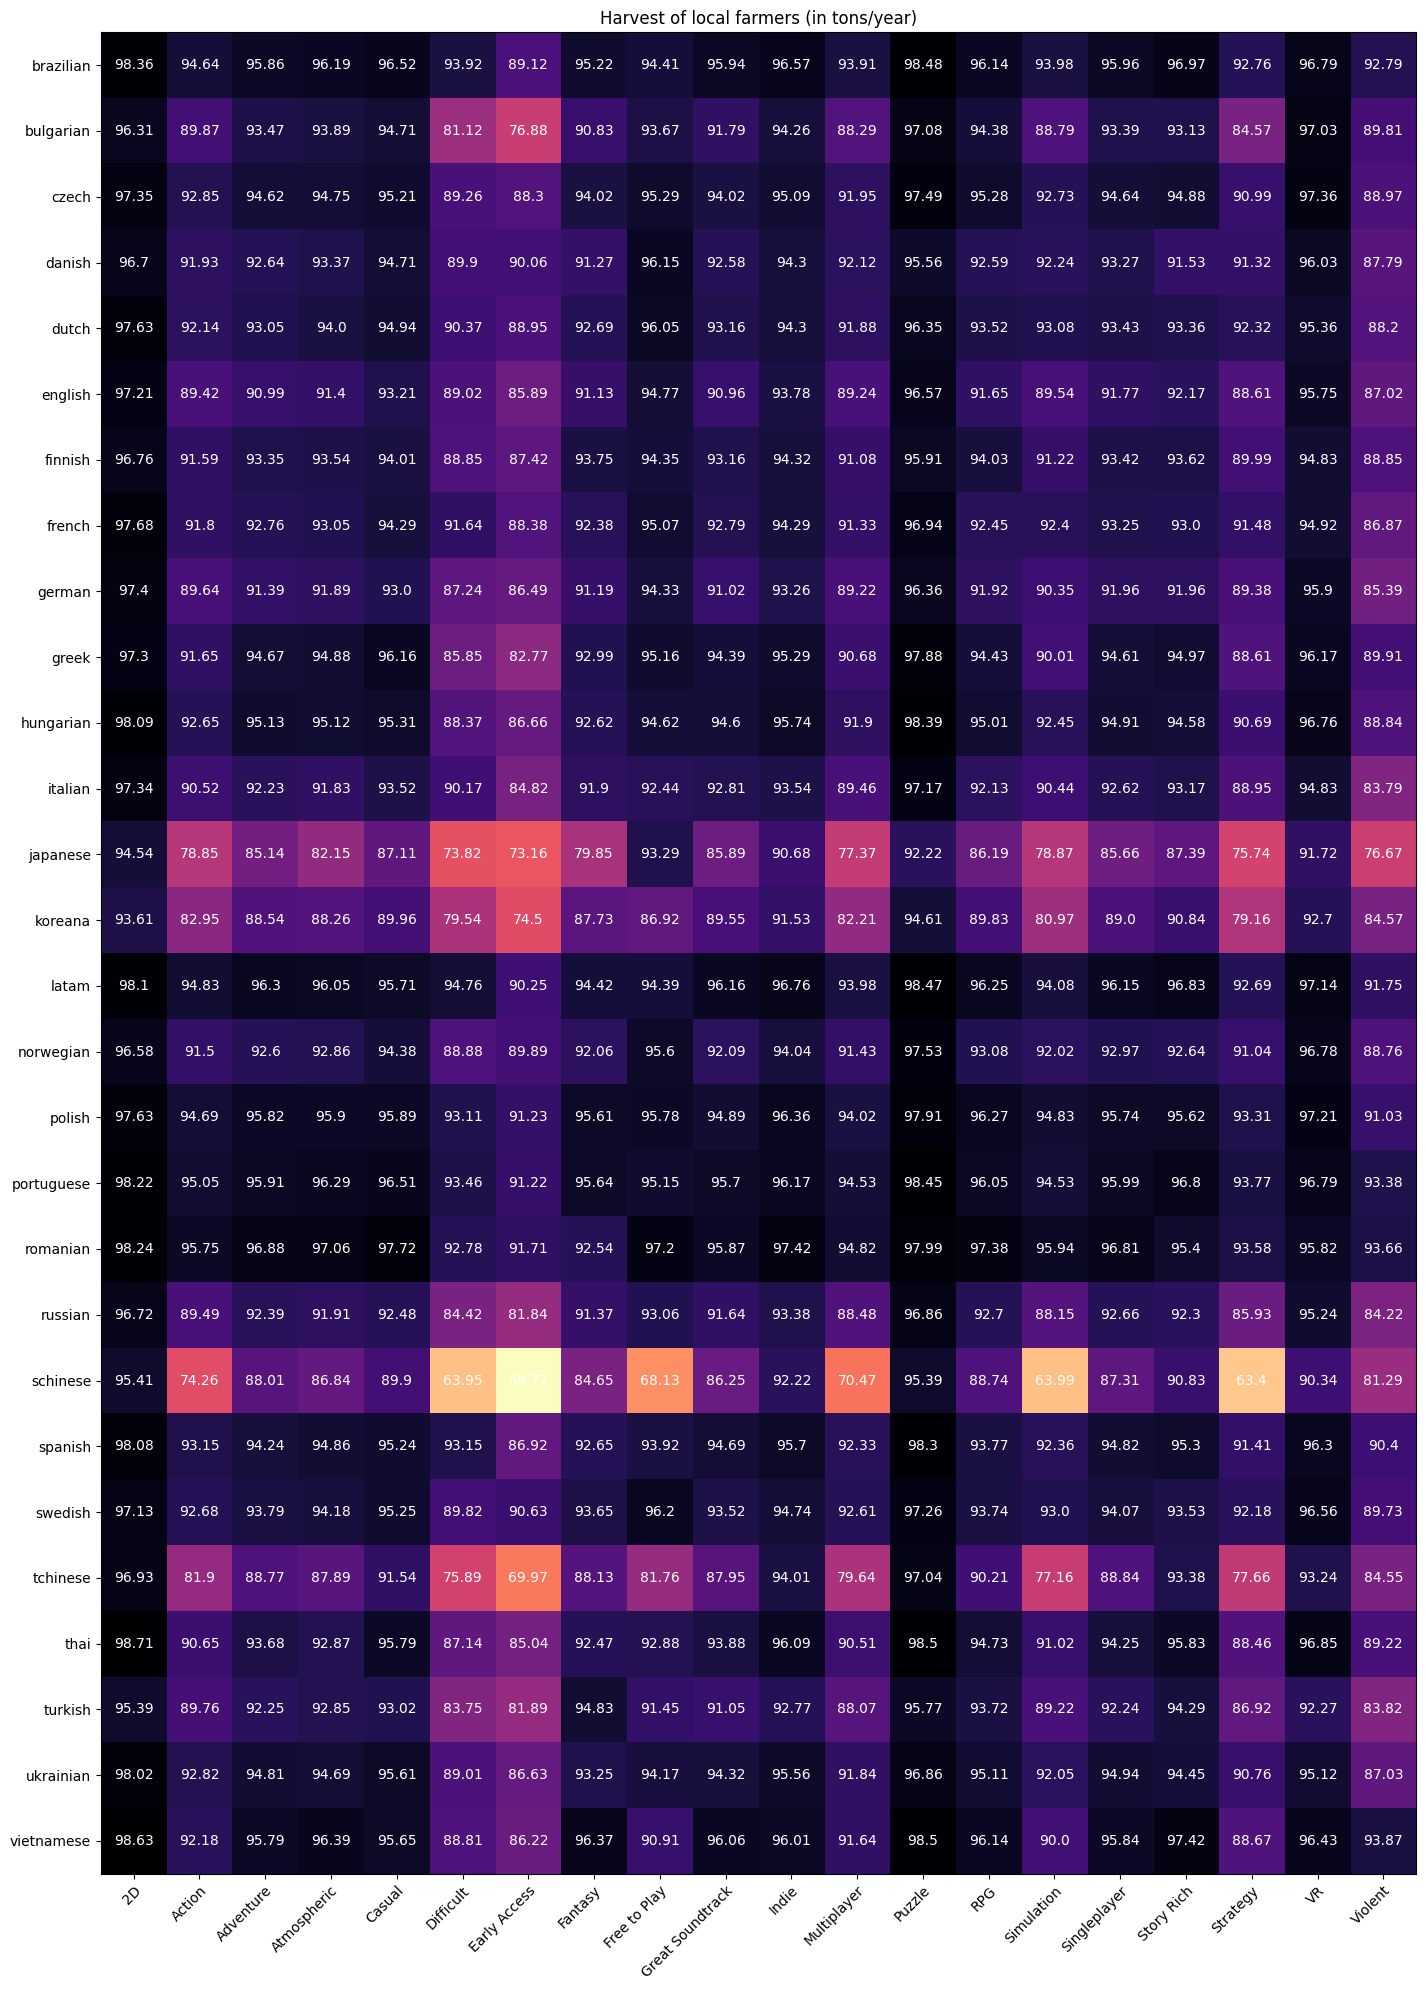

23/11/09 16:58:55 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1746941 ms exceeds timeout 120000 ms
23/11/09 16:58:55 WARN SparkContext: Killing executors is not supported by current scheduler.
23/11/09 16:59:00 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at s

In [107]:
# print(top_20_tags_names)
# print(languages_names)
H = len(top_20_tags_names)
W = len(languages_names)

from matplotlib.pyplot import plot
import numpy as np

matrix_np = np.array(matrix)

fig, ax = plt.subplots(figsize=(30, 20))
im = ax.imshow(matrix_np, cmap="magma_r")

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(top_20_tags_names)), labels=top_20_tags_names)
ax.set_yticks(np.arange(len(languages_names)), labels=languages_names)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(languages_names)):
    for j in range(len(top_20_tags_names)):
        text = ax.text(j, i, matrix_np[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Harvest of local farmers (in tons/year)")
fig.tight_layout()
plt.show()

# # alphabets = ['A', 'B', 'C', 'D', 'E']
 
# # randomly generated array (r, c)
# random_array = np.random.random((H, W))
 
# figure = plt.figure(figsize=(50,30))
# axes = figure.add_subplot(111)
 
# # using the matshow() function 
# caxes = axes.matshow(matrix, interpolation ='nearest')
# figure.colorbar(caxes)
 
# axes.set_xticklabels(['']+top_20_tags_names)
# axes.set_yticklabels(['']+languages_names)
# print(top_20_tags_names)
# print(languages_names)
# # axes.set_size_inches(18.5, 10.5, forward=True)
# # figure.set_figwidth(20)
 
# plt.show()

## Language Count

In [55]:
languages = steam_reviews.groupBy("language").count().where(col("count") > 1000).sort(col("count").desc())

In [14]:
languages.show(30)

+----------+-------+
|  language|  count|
+----------+-------+
|   english|9635376|
|  schinese|3764936|
|   russian|2348872|
| brazilian| 837515|
|   spanish| 813308|
|    german| 752587|
|   turkish| 635851|
|   koreana| 613632|
|    french| 541745|
|    polish| 495514|
|  tchinese| 218202|
|     czech| 133979|
|   italian| 133307|
|      thai| 127503|
|  japanese|  81753|
|portuguese|  81385|
|   swedish|  80225|
|     dutch|  77555|
| hungarian|  71000|
|     latam|  70103|
|    danish|  55914|
|   finnish|  54711|
| norwegian|  36797|
|  romanian|  32727|
| ukrainian|  21168|
|     greek|  14472|
| bulgarian|  10454|
|vietnamese|   6580|
+----------+-------+



In [15]:
languages.count()

28